# Tarea 2: Piping y Bombas
### Pablo Correa e Ian Gross

## Librerías

In [34]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
import scipy.constants as cte
import scipy.optimize as opt
import matplotlib.pyplot as plt

from fluids.units import *

In [35]:
g = cte.g*u.m/u.s**2

## Problema 1

Considere el sistema de distribución de agua en la figura, donde la presión en A es 150 psig.

Considerando las tuberías de entrada y salida 1 y 2 respectivamente, y las tuberías paralelas A, B y C desde arriba hacia abajo, se tiene que:

In [36]:
# datos
z_A = (100*u.ft).to(u.m)
z_B = (120*u.ft).to(u.m)

L_1 = (2000*u.ft).to(u.m)
L_2 = (4000*u.ft).to(u.m)
L_A = (3000*u.ft).to(u.m)
L_B = (2000*u.ft).to(u.m)
L_C = (3000*u.ft).to(u.m)
L = [L_1, L_2, L_A, L_B, L_C]

D_1 = (24*u.inch).to(u.m)
D_2 = (30*u.inch).to(u.m)
D_A = (14*u.inch).to(u.m)
D_B = (12*u.inch).to(u.m)
D_C = (16*u.inch).to(u.m)
D = [D_1, D_2, D_A, D_B, D_C]

A_1 = np.pi * D_1**2 / 4
A_2 = np.pi * D_2**2 / 4
A_A = np.pi * D_A**2 / 4
A_B = np.pi * D_B**2 / 4
A_C = np.pi * D_C**2 / 4
A = [A_1, A_2, A_A, A_B, A_C]

Q = (20*u.cubic_feet/u.s).to(u.m**3/u.s)
P_1 = ((150 + 14.7)*u.psi).to(u.Pa) # psig = psi + 14.7
T = 300*u.K # Asumiendo temperatura ambiente
epsilon = (0.0015*u.mm).to(u.m) # Asumiendo tubería de PVC [1]

rho = cp.PropsSI('D', 'P', P_1.magnitude, 'T', T.magnitude, 'Water')*u.kg/u.m**3
mu = cp.PropsSI('V', 'P', P_1.magnitude, 'T', T.magnitude, 'Water')*u.Pa*u.s

a. La pérdida de carga desde A a B, si es que solo la tubería A es utilizada.

Considerando que solo se usa la tubería A, los caudales serían:

$$\dot{\forall} = \dot{\forall}_1 = \dot{\forall}_2 = \dot{\forall}_A$$
$$\dot{\forall}_B = \dot{\forall}_C = 0$$

Además, se sabe que las pérdidas de carga corresponderían a las pérdidas por fricción en los tramos y no hay singularidades, por lo tanto:

$$\Delta P = \Delta P_1 + \Delta P_2 + \Delta P_A + \rho g \Delta z$$
$$\Delta P_i = f_i \rho \frac{L_i}{D_i} \frac{V_i^2}{2}$$

Siendo $V_i$ la velocidad promedio en el tramo. Suponiendo que el caudal es constante a lo largo del tramo, y que las tuberías tienen perfil circular, se puede estimar que las velocidades serían:

$$V_i = \frac{\dot{\forall}_i}{A_i} = \frac{4 \dot{\forall}}{\pi D_i^2}$$

Con esta expresión, la pérdida total sería

$$\Delta P = \frac{\rho}{2} (f_1 \frac{L_1}{D_1} V_1^2 + f_2 \frac{L_2}{D_2} V_2^2 + f_A \frac{L_A}{D_A} V_A^2) + \rho g (z_B - z_A)$$

In [37]:
v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q / A_A

Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)

DP_1 = rho/2*(f_1*L_1/D_1*v_1**2 + f_A*L_A/D_A*v_A**2 + f_2*L_2/D_2*v_2**2) + rho*g*(z_B - z_A)
print(f"La pérdida de carga total es {DP_1.to(u.kPa)}")

La pérdida de carga total es 522.3806550009081 kilopascal


b. La pérdida de carga desde A a B, si es que las tuberías A y B son utilizadas.

Considerando que se usan las tuberías A y B, se puede suponer que los caudales tienen las siguientes relaciones:

$$\dot{\forall} = \dot{\forall}_A + \dot{\forall}_B$$
$$\dot{\forall}_C = 0$$

Por otro lado, como las tuberías se encuentran paralelas se sabe que:

$$\Delta P_A = \Delta P_B$$
$$\Delta P_A - \Delta P_B = 0$$

Reemplazando las expresiones de velocidad y presión de la parte (a.) se tiene que:

$$A_A V_A + A_B V_B = \dot{\forall}$$
$$f_A \frac{\rho}{2} \frac{L_A}{D_A} V_A^2 - f_B \frac{\rho}{2} \frac{L_B}{D_B} V_B^2 = 0$$

Se da un ansatz de la distribución inicial de caudales. Luego, se itera sobre estos valores hasta llegar a un resultado parejo.

In [38]:
# Ansatz e iteración manual. Asegurando la conservación del caudal.
xb = 0.546366
Q_A = xb*Q
Q_B = (1-xb)*Q

v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q_A / A_A
v_B = Q_B / A_B

Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)
Re_B = fld.Reynolds(D=D_B, rho=rho, mu=mu, V=v_B)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)
f_B = fld.friction.friction_factor(Re_B, eD=epsilon/D_B)

# Se debe dar igualdad de presiones para A y B
P_A = rho*f_A*L_A/D_A*v_A**2/2
P_B = rho*f_B*L_B/D_B*v_B**2/2

print(f"La pérdida de carga en A es {P_A.to(u.Pa)}")
print(f"La pérdida de carga en B es {P_B.to(u.Pa)}")
print(f"La diferencia de presiones es {(P_A - P_B).to(u.Pa)}")

La pérdida de carga en A es 140123.58084382655 pascal
La pérdida de carga en B es 140123.42375500116 pascal
La diferencia de presiones es 0.15708882539183833 pascal


In [39]:
# Sumando las pérdidas de carga 1 y 2 y la diferencia de alturas
DP_2 = rho/2*(f_1*L_1/D_1*v_1**2 + f_A*L_A/D_A*v_A**2 + f_2*L_2/D_2*v_2**2) + rho*g*(z_B - z_A)
print(f"La pérdida de carga total es {DP_2.to(u.kPa)}")

La pérdida de carga total es 234.6940843388837 kilopascal


c. La pérdida de carga desde A a B, si es que las 3 tuberías son utilizadas.

Considerando ahora todas las tuberías, se tiene que:

$$\dot{\forall} = \dot{\forall}_A + \dot{\forall}_B + \dot{\forall}_C$$
$$\Delta P_A = \Delta P_B = \Delta P_C$$

Por lo tanto:

$$\dot{\forall}_A + \dot{\forall}_B + \dot{\forall}_C = \dot{\forall}$$
$$\Delta P_A - \Delta P_B = 0$$
$$\Delta P_A - \Delta P_C = 0$$

Reemplazando las expresiones, se tiene que:

$$A_A V_A + A_B V_B + A_C V_C = \dot{\forall}$$
$$f_A \frac{\rho}{2} \frac{L_A}{D_A} V_A^2 - f_B \frac{\rho}{2} \frac{L_B}{D_B} V_B^2 = 0$$
$$f_A \frac{\rho}{2} \frac{L_A}{D_A} V_A^2 - f_C \frac{\rho}{2} \frac{L_C}{D_C} V_B^2 = 0$$

In [40]:
# Ansatz e iteración manual. Asegurando la conservación del caudal.
xc = 0.3073715
yc = 0.255237
Q_A = xc*Q
Q_B = yc*Q
Q_C = (1-xc-yc)*Q

v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q_A / A_A
v_B = Q_B / A_B
v_C = Q_C / A_C
v_tag = ['v_1', 'v_2', 'v_A', 'v_B', 'v_C']
v = [v_1, v_2, v_A, v_B, v_C]


Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)
Re_B = fld.Reynolds(D=D_B, rho=rho, mu=mu, V=v_B)
Re_C = fld.Reynolds(D=D_C, rho=rho, mu=mu, V=v_C)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)
f_B = fld.friction.friction_factor(Re_B, eD=epsilon/D_B)
f_C = fld.friction.friction_factor(Re_C, eD=epsilon/D_C)
f = [f_1, f_2, f_A, f_B, f_C]

# Se debe dar igualdad de presiones para A y B
P_A = rho*f_A*L_A/D_A*v_A**2/2
P_B = rho*f_B*L_B/D_B*v_B**2/2
P_C = rho*f_C*L_C/D_C*v_C**2/2

print(f"La presión en A es {P_A.to(u.kPa)}")
print(f"La presión en B es {P_B.to(u.kPa)}")
print(f"La presión en C es {P_C.to(u.kPa)}\n")

print(f"La diferencia de presiones A-B es {(P_A - P_B).to(u.Pa)}")
print(f"La diferencia de presiones A-C es {(P_A - P_C).to(u.Pa)}")
print(f"La diferencia de presiones B-C es {(P_B - P_C).to(u.Pa)}")

La presión en A es 48.76796414776605 kilopascal
La presión en B es 48.76769734585945 kilopascal
La presión en C es 48.76797488749972 kilopascal

La diferencia de presiones A-B es 0.266801906596811 pascal
La diferencia de presiones A-C es -0.010739733668742701 pascal
La diferencia de presiones B-C es -0.2775416402655537 pascal


In [41]:
# Sumando las pérdidas de carga 1 y 2 y la diferencia de alturas
DP_3 = rho/2*(f_1*L_1/D_1*v_1**2 + f_A*L_A/D_A*v_A**2 + f_2*L_2/D_2*v_2**2) + rho*g*(z_B - z_A)
print(f"La pérdida de carga total es {DP_3.to(u.kPa)}")

La pérdida de carga total es 143.33846764282322 kilopascal


d. Determine la potencia requerida (en caballos de fuerza) para hacer la presión en B sea igual
a A, en los 3 ítems anteriores.

In [42]:
P_B_1 = P_1 - DP_1
P_B_2 = P_1 - DP_2
P_B_3 = P_1 - DP_3

hp_1 = P_B_1*Q
hp_2 = P_B_2*Q
hp_3 = P_B_3*Q

print(f"La presión en B calculada con el primer método es {P_B_1}")
print(f"La presión en B calculada con el segundo método es {P_B_2}")
print(f"La presión en B calculada con el tercer método es {P_B_3}\n")

print(f"Caballos de potencia requeridos con el primer método es {hp_1.to(u.hp)}")
print(f"Caballos de potencia requeridos con el segundo método es {hp_2.to(u.hp)}")
print(f"Caballos de potencia requeridos con el tercer método es {hp_3.to(u.hp)}")

La presión en B calculada con el primer método es 613185.8711839214 pascal
La presión en B calculada con el segundo método es 900872.4418459458 pascal
La presión en B calculada con el tercer método es 992228.0585420062 pascal

Caballos de potencia requeridos con el primer método es 465.6964794657692 horsepower
Caballos de potencia requeridos con el segundo método es 684.1858958774858 horsepower
Caballos de potencia requeridos con el tercer método es 753.5677767623746 horsepower


e. A partir de los resultados obtenidos en (d.) ¿Que puede concluir a partir de a utilización de
tubería sen paralelos para sistemas de bombeo?

Las tuberías en paralelo implican que cada tramo de tubería tendrá un menor caudal y, por lo tanto, una menor pérdida por fricción. Por el mismo motivo, más tuberías en paralelo también pueden implicar descebado de la bomba, pues el caudal no es el suficiente para utilizar el área superficial de la tubería.

Por otro lado, el caudal se distribuye en proporción al tamaño de las tuberías y la resistencia que estas impongan al flujo del agua. Las velocidades en cada camino serán diferentes en función de este caudal.

f. Considerando una bomba modelo B3Z-M en el tramo 1 (L=2000ft y D=24in), con un
rodete de 8,438” (Página 45 del catálogo Berkeley). Determinar el caudal de operación en cada
tramo de tubería.

Se considera solo el casos 1c. con todas las tuberías funcionando.

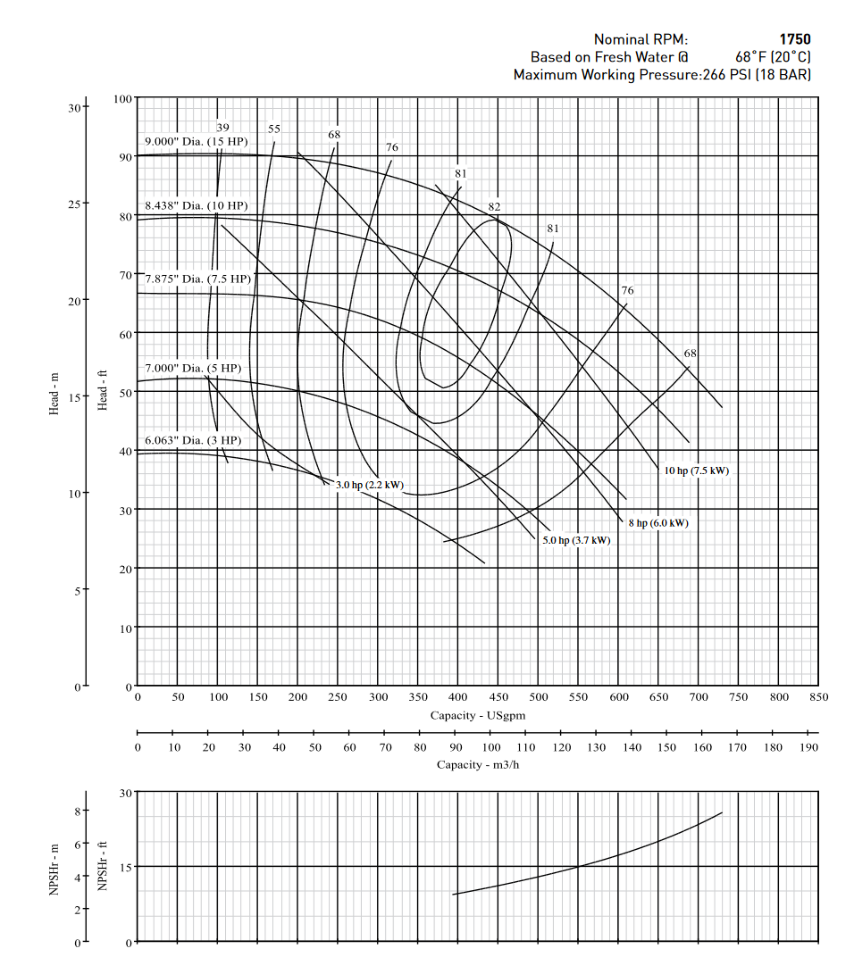

In [43]:
# plt pixmap for image
plt.figure(dpi=250)
plt.imshow(plt.imread("P1.f.png"))
plt.axis('off')
plt.show()

In [44]:
Hp = 0
for vi in range(len(v)):
    Hpi = f[vi]*L[vi]/D[vi]*v[vi]**2/(2*g)
    Hp += Hpi
print(f"La pérdida de carga total es {round(Hp.to(u.m),2)} o {round(Hp.to(u.ft),2)}")

La pérdida de carga total es 18.54 meter o 60.83 foot


Utilizando la curva de rodete 8.438" y un head pump total de 60.83'. Se utiliza la tabla de la bomba para calcular el caudal total.

In [45]:
Qp = 540*u.gal/u.min
Qp = Qp.to(u.m**3/u.s)
print(f"Usando los valores de la tabla se obtiene un caudal aportado de: {round(Qp,4)}")
Qt = Q + Qp
print(f"Adicionando el caudal inicial se obtiene {round(Qt,4)}")
Qtx = xc*Qt
Qty = yc*Qt
Qtz = (1-xc-yc)*Qt
print("Se obtienen los caudales")
print(f"Q1: {round(Qt,4)}")
print(f"QA: {round(Qtx,4)}")
print(f"QB: {round(Qty,4)}")
print(f"QC: {round(Qtz,4)}")
print(f"Q2: {round(Qt,4)}")

Usando los valores de la tabla se obtiene un caudal aportado de: 0.0341 meter ** 3 / second
Adicionando el caudal inicial se obtiene 0.6004 meter ** 3 / second
Se obtienen los caudales
Q1: 0.6004 meter ** 3 / second
QA: 0.1845 meter ** 3 / second
QB: 0.1532 meter ** 3 / second
QC: 0.2626 meter ** 3 / second
Q2: 0.6004 meter ** 3 / second


g. Considerando la misma bomba usada en (f) pero instalada en el tramo central (L=2000ft y
D=24in). Determinar la distriubución del caudal de operación.

Dado que la bomba se encuentra ahora dentro de las tuberías paralelas, cambiarán las proporciones de caudal entre los paralelos.

In [46]:
# Ansatz e iteración manual. Asegurando la conservación del caudal.
xg = 0.325877
yg = 0.210445
Q_A = xg*Q
Q_B = yg*Q + Qp
Q_C = (1-xg-yg)*Q

v_1 = Q / A_1
v_2 = Q / A_2
v_A = Q_A / A_A
v_B = Q_B / A_B
v_C = Q_C / A_C
v = [v_1, v_2, v_A, v_B, v_C]

Re_1 = fld.Reynolds(D=D_1, rho=rho, mu=mu, V=v_1)
Re_2 = fld.Reynolds(D=D_2, rho=rho, mu=mu, V=v_2)
Re_A = fld.Reynolds(D=D_A, rho=rho, mu=mu, V=v_A)
Re_B = fld.Reynolds(D=D_B, rho=rho, mu=mu, V=v_B)
Re_C = fld.Reynolds(D=D_C, rho=rho, mu=mu, V=v_C)

f_1 = fld.friction.friction_factor(Re_1, eD=epsilon/D_1)
f_2 = fld.friction.friction_factor(Re_2, eD=epsilon/D_2)
f_A = fld.friction.friction_factor(Re_A, eD=epsilon/D_A)
f_B = fld.friction.friction_factor(Re_B, eD=epsilon/D_B)
f_C = fld.friction.friction_factor(Re_C, eD=epsilon/D_C)
f = [f_1, f_2, f_A, f_B, f_C]

# Se debe dar igualdad de presiones para A y B
P_A = rho*f_A*L_A/D_A*v_A**2/2
P_B = rho*f_B*L_B/D_B*v_B**2/2
P_C = rho*f_C*L_C/D_C*v_C**2/2

print(f"La diferencia de presiones A-B es {(P_A - P_B).to(u.Pa)}")
print(f"La diferencia de presiones A-C es {(P_A - P_C).to(u.Pa)}")
print(f"La diferencia de presiones B-C es {(P_B - P_C).to(u.Pa)}")

La diferencia de presiones A-B es 0.3893020492614596 pascal
La diferencia de presiones A-C es -0.41076935012824833 pascal
La diferencia de presiones B-C es -0.800071399389708 pascal


In [47]:
Hp = 0
for vi in range(len(v)):
    Hpi = f[vi]*L[vi]/D[vi]*v[vi]**2/(2*g)
    Hp += Hpi

print(f"La pérdida de carga total es {round(Hp.to(u.ft),2)}\n")
Qp2 = (470*u.gal/u.min).to(u.m**3/u.s)
print(f"El caudal aportado por la bomba es {round(Qp2,4)}")
Qt2 = Q + Qp2
print(f"El caudal total es {round(Qt2,4)}\n")
Qt2x = xg*Qt2
Qt2y = yg*Qt2
Qt2z = (1-xg-yg)*Qt2
print("Se obtienen los caudales")
print(f"Q1: {round(Qt2,4)}")
print(f"QA: {round(Qt2x,4)}")
print(f"QB: {round(Qt2y,4)}")
print(f"QC: {round(Qt2z,4)}")
print(f"Q2: {round(Qt2,4)}")

La pérdida de carga total es 66.37 foot

El caudal aportado por la bomba es 0.0297 meter ** 3 / second
El caudal total es 0.596 meter ** 3 / second

Se obtienen los caudales
Q1: 0.596 meter ** 3 / second
QA: 0.1942 meter ** 3 / second
QB: 0.1254 meter ** 3 / second
QC: 0.2763 meter ** 3 / second
Q2: 0.596 meter ** 3 / second


## Problema 2

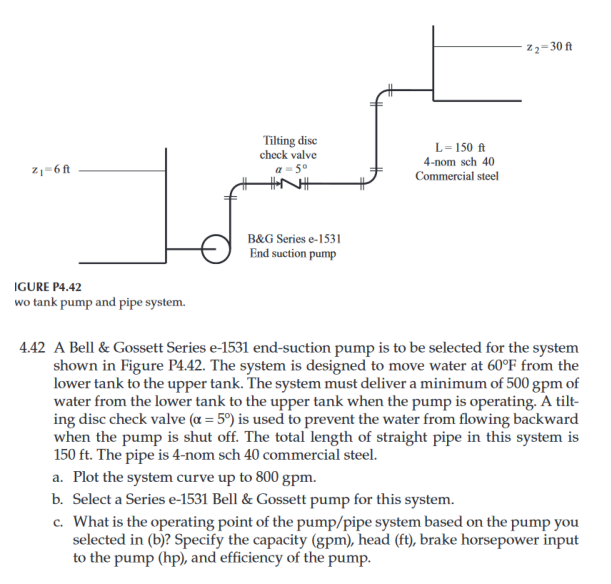

In [48]:
# plt pixmap for image
plt.figure(dpi=150)  # You can set it to any value you prefer, such as 200 or 300
plt.imshow(plt.imread("P2.png"))
plt.axis('off')
plt.show()

In [49]:
T = (60*u.fahrenheit).to(u.K)
P = (1*u.atm).to(u.Pa) # asumimos presion sobre agua en estanque de 1 atm
Q_min = (500*u.gallon/u.min).to(u.m**3/u.s) # caudal

rho = cp.PropsSI('D', 'P', P.magnitude, 'T', T.magnitude, 'Water')*u.kg/u.m**3
mu = cp.PropsSI('V', 'P', P.magnitude, 'T', T.magnitude, 'Water')*u.Pa*u.s

z1 = (6*u.ft).to(u.m)
z2 = (30*u.ft).to(u.m)

L = (150*u.ft).to(u.m)
D = (4*u.inch).to(u.m)
epsilon = fld.material_roughness("commercial steel")*u.m

A = np.pi * D**2 / 4

a. Plot the system curve up to 800 gpm.

Dado el sistema de dos reservorios, por ecuación modificada de Bernoulli se tiene que:

$$\frac{P_1}{\gamma} + \frac{V_1^2}{2g} + z_1 + H_p = \frac{P_2}{\gamma} + \frac{V_2^2}{2g} + z_2 + \bigg(f \frac{L}{D} + \sum{K}\bigg) \frac{V^2}{2g}$$

Suponiendo que los estanques están ambos abiertos a la atmosfera (por lo que $P_1 = P_2$) y suponiendo que la altura de columna de agua se mantiene constante en ambos estanques ($V_1 = V_2$), se puede reducir la ecuación de sistema a:

$$H_p = z_2 - z_1 + \bigg(f \frac{L}{D} + \sum{K}\bigg) \frac{V^2}{2g}$$

Luego, dada la definición del cadual y sabiendo que la tubería tiene perfil circular se tiene que la velocidad es

$$V = \frac{\dot{\forall}}{A} = \frac{4}{\pi D^2} \dot{\forall}$$

Por lo tanto la curva se reduce a

$$H_p = z_2 - z_1 + \bigg(f \frac{L}{D} + \sum{K}\bigg) \frac{8}{g\pi^2 D^4}\dot{\forall}^2$$

Para las singularidades, se considera que se presentan 3 codos de 90° y una "tilting disk check valve". El gráfico se genera desde 500 gpm (el mínimo requerido por el sistema) y 800 gpm.

Siendo que el flujo es turbulento, simplemente se utiliza el método de Crane a través de fluids para calcular los K-factor.

Número de Reynolds: 6324787.764369915
Cabezal mínimo: 71.92532829986678 foot


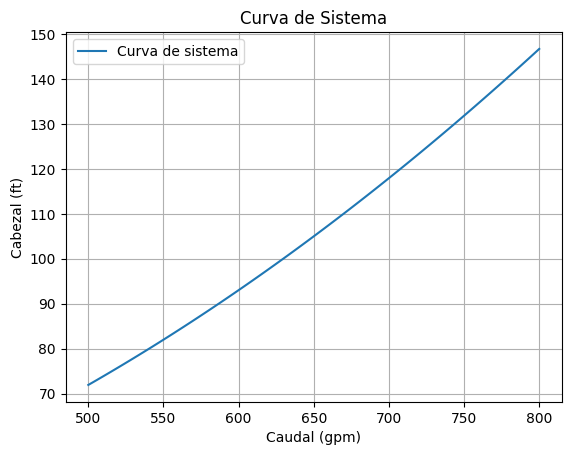

In [50]:
dz = z2 - z1

v = Q/A

Re = (fld.Reynolds(D=D, rho=rho, mu=mu, V=v)).to(u.dimensionless)

print(f"Número de Reynolds: {Re.magnitude}")

f = fld.friction.friction_factor(Re, eD=epsilon/D)

K_90_elbow = fld.fittings.bend_rounded_Crane(Di=D.magnitude, angle=90)
K_valve = fld.K_tilting_disk_check_valve_Crane(D=D.magnitude, angle = 5)

flow_rates = np.linspace(500, 800, 100)
velocities = (flow_rates*u.gallon/u.min).to(u.m**3/u.s) / A

total_head = dz + (f*L/D + 3*K_90_elbow + K_valve) * velocities**2 /(2*g)
total_head = (total_head).to(u.ft).magnitude

H_min = dz + (f*L/D + 3*K_90_elbow + K_valve) * (Q_min/A)**2 / (2*g)

print(f"Cabezal mínimo: {H_min.to(u.ft)}")

# plot curva de sistema
plt.plot(flow_rates, total_head, label='Curva de sistema')

# aspectos visuales
plt.xlabel('Caudal (gpm)')
plt.ylabel('Cabezal (ft)')
plt.title('Curva de Sistema')
plt.legend()
plt.grid(True)
plt.show()

b. Select a Series e-1531 Bell & Gossett pump for this system.

Considerando los rangos requeridos para el caudal (mínimo 500 gpm) y el mínimo correspondiente de cabezal que se calculó (aprox 72 ft), escogimos el modelo 3AD a 3500 RPM de la serie e-1531 Bell & Gossett (obtenido de la página 55 del archivo "Pump Curves - Penoncello"), siendo que puede operar con buena eficiencia en el rango de interés.

Superponiendo la curva del sistema, se puede observar que en 3500 RPM, el dominio de operación que nos interesa opera en esta bomba, demostrando que esta bomba es una opción viable para el sistema, independiente del punto de operación que se utilice finalmente.

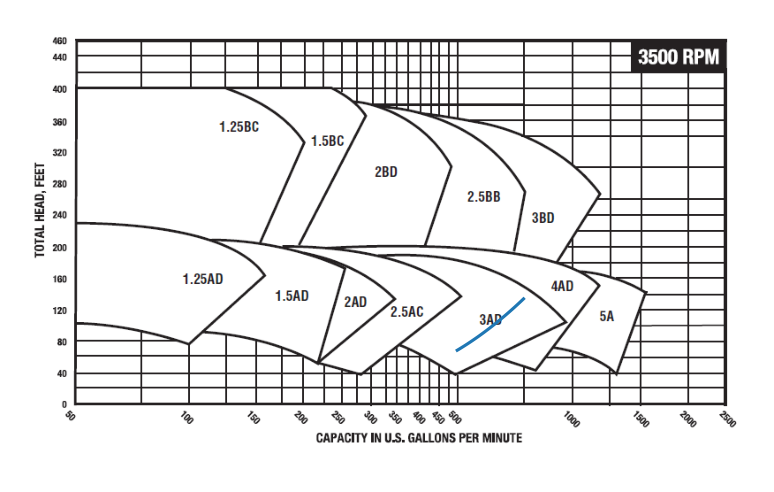

In [51]:
plt.figure(dpi=150)
plt.imshow(plt.imread("SelectionChart e-1531 3500rpm.png"))
plt.plot(flow_rates/4 + 375, (- total_head*7/9 + 435), label='Curva de sistema') # curva ajustada a la escala del diagrama
plt.axis('off')
plt.show()

c. What is the operating point of the pump/pipe system based on the pump you
selected in (b)? Specify the capacity (gpm), head (ft), brake horsepower input
to the pump (hp), and efficiency of the pump.

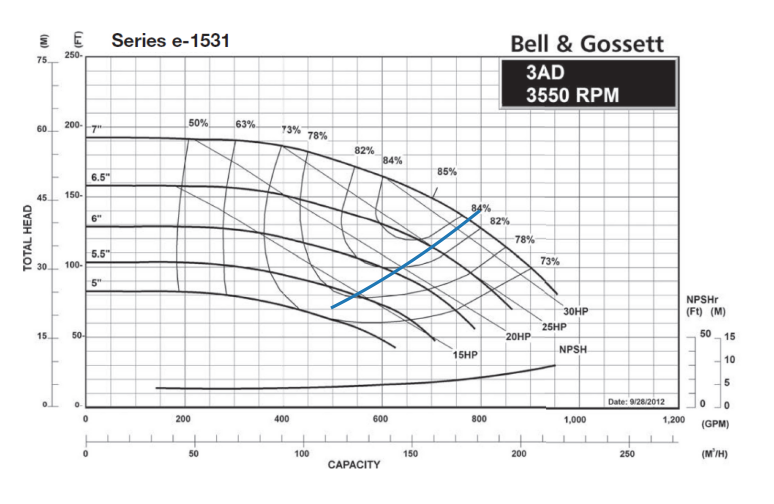

In [52]:
plt.figure(dpi=150)
plt.imshow(plt.imread("Curve e-1531 B&G.png"))
plt.plot(flow_rates*2/3 + 100, (- total_head*7/4 + 525), label='Curva de sistema')  # curva ajustada a la escala del diagrama
plt.axis('off')
plt.show()

Usando los puntos de intersección, la bomba puede operar con un 78% de eficiencia a 550 gpm generando 15 HP utilizando este modelo, produciendo un cabezal de 80 ft. Con este punto de intersección se cumple el requisito inicial de mínimo 500 gpm con 72 ft de cabezal.

## Problema 3

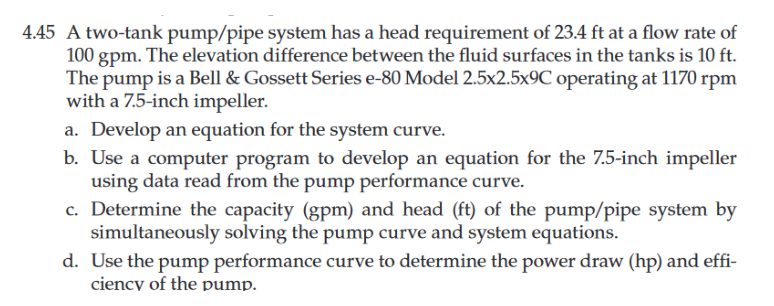

In [53]:
# plt pixmap for image
plt.figure(dpi=150)  # You can set it to any value you prefer, such as 200 or 300
plt.imshow(plt.imread("P3.png"))
plt.axis('off')
plt.show()

In [54]:
Hp_1 = 23.4*u.ft
Q_1 = 100*u.gallon/u.min

dz = 10*u.ft

a. Develop an equation for the system curve.

Dados los datos iniciales del problema, se sabe que:

$$\Delta z = z_2 - z_1 = 10 \text{ ft}$$
$$H_p (\dot{\forall} = 100 \text{ gpm}) = 23.4 \text{ ft}$$

Dada la ecuación modificada de Bernoulli, se sabe que la curva del sistema será de la forma:

$$H_p(\dot{\forall}) = \Delta z + C \dot{\forall}^2$$

Resolviendo, se tiene que:

$$23.4 = 10 + C \times 100^2$$

In [55]:
C_system = (Hp_1 - dz)/Q_1**2
print(C_system.magnitude)

0.0013399999999999998


Por lo tanto, se tiene que la ecuación sería finalmente:

$$H_p (\dot{\forall}) = 0.00134 \dot{\forall}^2 + 10 \text{ ft}$$

b. Use a computer program to develop an equation for the 7.5-inch impeller
using data read from the pump performance curve.

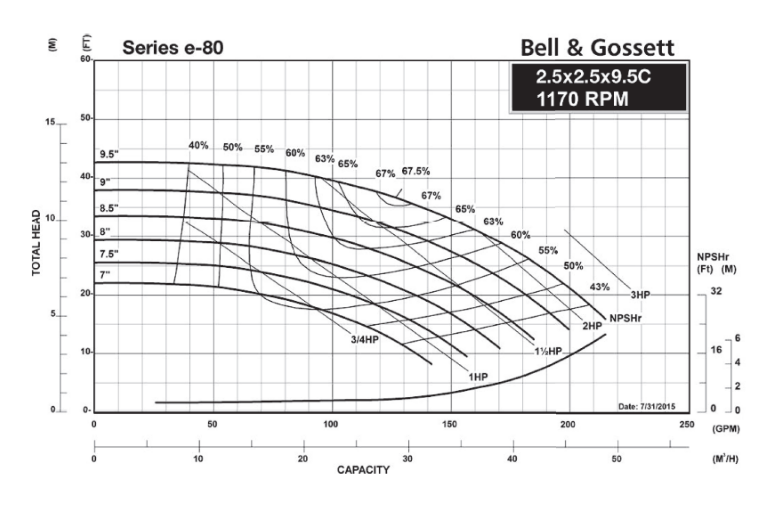

In [56]:
plt.figure(dpi=150)
plt.imshow(plt.imread("Curve e-80 B&G.png"))
plt.axis('off')
plt.show()

Observando la curva de 7.5'', se toma una muestra de datos aproximados dentro del rango entre 0 y 150 GPM. La curva aproximada resulta siendo:

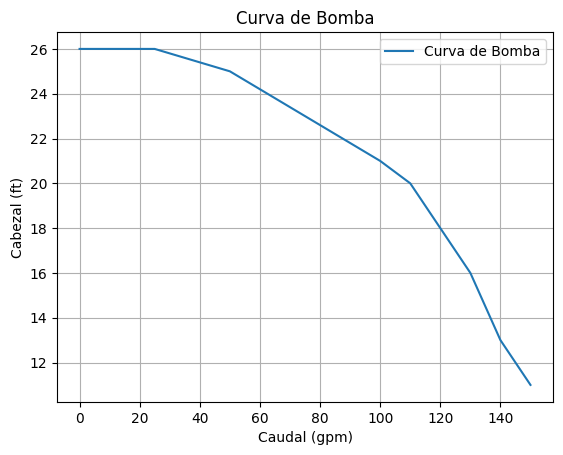

In [57]:
capacities = [0, 25, 50, 75, 100, 110, 120, 130, 140, 150]
heads = [26, 26, 25, 23, 21, 20, 18, 16, 13, 11]

plt.plot(capacities, heads, label='Curva de Bomba')

# aspectos visuales
plt.xlabel('Caudal (gpm)')
plt.ylabel('Cabezal (ft)')
plt.title('Curva de Bomba')
plt.legend()
plt.grid(True)
plt.show()

Luego suponiendo que la ecuación de la curva de la bomba sigue la forma:

$$H_p(Q) = aQ^2 + bQ + c$$

Se usan los datos para ajustar la curva a continuación, resulta en una curva con los coeficientes:

Coeficiente a: -0.000920441750267489
Coeficiente b: 0.04288905034293093
Coeficiente c: 25.63559071450663


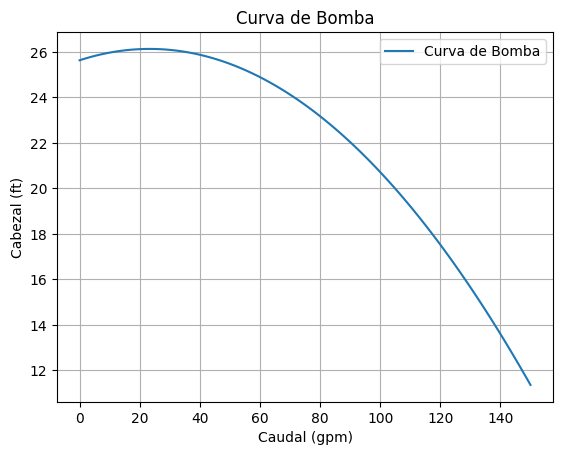

In [58]:
def pump_curve(x, a, b, c):
    return a*x**2 + b*x + c

curve_param, curve_param_cov = opt.curve_fit(f=pump_curve,xdata=capacities,ydata=heads)

print(f"Coeficiente a: {curve_param[0]}")
print(f"Coeficiente b: {curve_param[1]}")
print(f"Coeficiente c: {curve_param[2]}")

test_rates = np.linspace(0,150,100)
pump_heads = curve_param[0]*test_rates**2 + curve_param[1]*test_rates + curve_param[2]

plt.plot(test_rates, pump_heads, label='Curva de Bomba')  # Convert flow rates to L/s for plot

# aspectos visuales
plt.xlabel('Caudal (gpm)')
plt.ylabel('Cabezal (ft)')
plt.title('Curva de Bomba')
plt.legend()
plt.grid(True)
plt.show()

c. Determine the capacity (gpm) and head (ft) of the pump/pipe system by
simultaneously solving the pump curve and system equations.

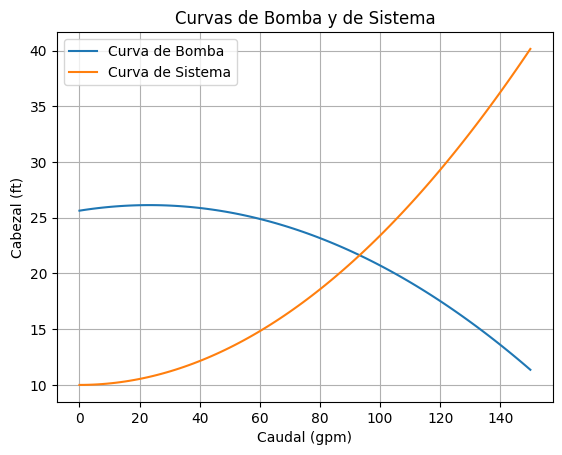

In [59]:
system_heads = C_system.magnitude*test_rates**2 + dz.magnitude

plt.plot(test_rates, pump_heads, label='Curva de Bomba')
plt.plot(test_rates, system_heads, label='Curva de Sistema')

# aspectos visuales
plt.xlabel('Caudal (gpm)')
plt.ylabel('Cabezal (ft)')
plt.title('Curvas de Bomba y de Sistema')
plt.legend()
plt.grid(True)
plt.show()

Teniendo las ecuaciones de la curva de bomba y la curva del sistema:

$$H_{system} (Q) = C_{system} Q^2 + \Delta z$$
$$H_{pump} (Q) = aQ^2 + bQ +c$$

Igualando las curvas para obtener el punto de operación se tiene que

$$H_{system} (Q) = H_{pump} (Q)$$
$$C_{system} Q^2 + \Delta z = aQ^2 + bQ + c$$
$$(a - C_{system})Q^2 + bQ + (c - \Delta z) = 0$$

In [60]:
a,b,c = curve_param
C_system = C_system.magnitude

caudal_op_1 = (-b + np.sqrt(b**2 - 4*(a-C_system)*(c-dz.magnitude)))/(2*(a-C_system))
caudal_op_2 = (-b - np.sqrt(b**2 - 4*(a-C_system)*(c-dz.magnitude)))/(2*(a-C_system))

print(f"Solución 1: {caudal_op_1}")
print(f"Solución 2: {caudal_op_2}")

Solución 1: -74.22126042454217
Solución 2: 93.19500763030656


Siendo que solo es de interés un caudal positivo, se continúa con la segunda solución, por lo que el caudal de operación sería de 93.19 GPM.

In [61]:
head_op = C_system * caudal_op_2**2 + dz.magnitude

print(f"Caudal de Operación: {caudal_op_2} GPM")
print(f"Cabezal de Operación: {head_op} ft")

Caudal de Operación: 93.19500763030656 GPM
Cabezal de Operación: 21.638314659265284 ft


d. Use the pump performance curve to determine the power draw (hp) and efficiency
of the pump.

Para poder resolverlo, se utilizarán las fórmulas entregadas por la documentación de las bombas serie e-80.

$$\dot{W}_{brake} = \frac{\rho g Q_{op} H_{op}}{3960 \times \eta_{pump}}$$
$$\dot{W}_{water} = \frac{\rho g Q_{op} H_{op}}{3960}$$
$$\eta_{pump} = \frac{\dot{W}_{water}}{\dot{W}_{brake}}$$

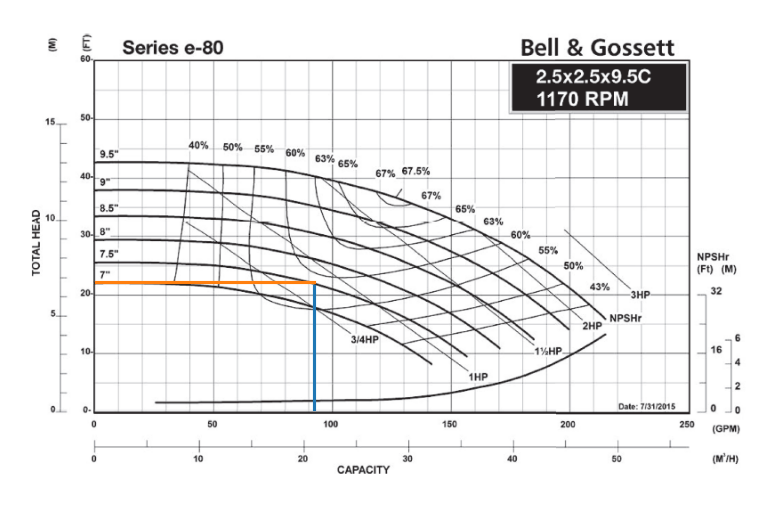

In [62]:
plt.figure(dpi=150)
plt.imshow(plt.imread("Curve e-80 B&G.png"))
plt.axis('off')

plt.plot(100*np.ones(100) + 235, 100*np.linspace(0,1,100)*11/8 + 305)
plt.plot(100*np.linspace(0,1,100)*2.45 + 90, 100*np.ones(100) + 200)

plt.show()

Se puede observar que la potencia de la bomba en el punto de operación se encontraría entre las rectas de 3/4 HP y 1 HP, mientras que la eficiencia estaría entre las curvas de 55% y 60%.

Luego se obtendrían los valores interpolando a partir del diagrama por interpolación lineal en base al cabezal.

In [63]:
hp_op = 0.75 + (head_op - 18)/(26 - 18)*(1 - 0.75)
ef_op = 55 + (head_op - 18)/(23 - 18)*(60 - 55)

print(f"Potencia de Bomba: {hp_op} HP")
print(f"Eficiencia de Bomba: {ef_op} %")

Potencia de Bomba: 0.8636973331020401 HP
Eficiencia de Bomba: 58.63831465926528 %


## Problema 4

Considere el plano hidráulico de la localidad de Hualañé. Establezca un código computracional que
permita optimizar lls diámetros de tuberñia de la red hidráulica considerada en la Tarea 1. El objetivo de la optimización es que la diferencia de presiones enre las acometidas de las casas sea lo menor posible,
siempre considerando que la presión debe ser mayor a lo establecido por la nomrma de sistemas sanitarios. 

Considerando el caso extremo, cuando todas las casas tienen una llave de lavamanos abierta, determine el cabezal que debería sumiinistrar el sistema de bombreo.

De acuerdo a la Superintendencia de Servicios Sanitarios, "el Manual de Proyectos de Agua Potable Rural 2019, dicta que los servicios que fueron construidos y rehabilitados a partir del año 2020 deberán tener una presión mínima de servicio de 15 metros columna de agua (1,5 bar), y una máxima de 70 metros columna de agua (7bar)". Además, la pérdida de carga en el arranque no debe superar los 5mca al abrir la llave [2].

Con respecto al caudal, este presenta una decisión de diseño, "el caudal recomendado para uso doméstico es entre 10 y 18 litros por minuto" [3]. Considerando una llave abierta por cada casa, y un total de 20 casas conectadas a la red (+2 desconectadas), el caudal debe ser un mínimo de $200Lmin^{-1}$ o $220Lmin^{-1}$ considerando que las otras dos casas se puedan conectar a la red.

Como en este caso, todas las casas se encuentran paralelas en el circuito, la presión sin considerar pérdidas de carga deberá ser para todas las casas igual.

In [76]:
Q = (220*u.L/u.min).to(u.m**3/u.s)
T = (20*u.celsius).to(u.K) # Temperatura del suelo
P = (1.51*u.MPa).to(u.Pa) # Considerando la mínima presión requerida por norma

epsilon = (0.0015*u.mm).to(u.m) # Rugosidad del tubo [5]

rho = cp.PropsSI('D','T', T.magnitude, 'P', P.magnitude, 'water')*u.kg/u.m**3
mu = cp.PropsSI('V','T', T.magnitude, 'P', P.magnitude, 'water')*u.Pa*u.s

In [77]:
D = np.linspace(0.5, 3, 100)*u.m
A = np.pi*D**2/4
v = Q/A

Re = fld.Reynolds(D=D, rho=rho, mu=mu, V=v)
f = []
for i in range(len(Re)):
    fi = fld.friction.friction_factor(Re[i], eD=epsilon/D[i]).to(u.dimensionless)
    f.append(fi)

print(Re.to(u.dimensionless))
print(f)

[9315.496320740134 8867.63592070455 8460.863630763975 8089.773120642749 7749.866687002297 7437.372062526398 7149.101827544755 6882.344296666219 6634.7779550595205 6404.403720508843 6189.490843981701 5988.533349047229 5800.21469027216 5623.37887654435 5457.00672043357 5300.196182490077 5152.146009794824 5012.142042137355 4879.545691816261 4753.78420491378 4634.342390719966 4520.755567418007 4412.60352035059 4309.505307258287 4211.114775129103 4117.11667746997 4027.2233002326348 3941.171520313135 3858.7202332772936 3779.648097349481 3703.751549209933 3630.843054146745 3560.7495588929473 3493.3111202775503 3428.3796868151426 3365.818013698078 3305.498694456177 3247.303294905892 3191.1215770009467 3136.8508018818825 3084.3951028537567 3033.6649202410313 2984.5764911109172 2937.0513877492785 2891.0160995400415 2846.4016535594865 2803.1432697667888 2761.180047165489 2720.4546777382693 2680.913185329283 2642.5046869721295 2605.1811744442757 2568.89731407597 2533.6102630584433 2499.27950068637

In [78]:
# Largo de la tubería principal por tramos
Lp1 = 48.55
Lp2 = np.sqrt(4.79**2 + 1.03**2) + np.sqrt(120**2+ (108.17-101.03)**2) + np.sqrt(20**2 + (144.79-124.79)**2) + 4
Lp3 = 16 + np.sqrt(216**2 + 120.748**2-111.198**2)
Lp4 = np.sqrt(40**2 + (404.79-364.79)**2)
Lp5 = 14.28
LpT = [Lp1, Lp2, Lp3, Lp4, Lp5]*u.m

# Largo de tuberías secundarias por tramos
Ls1 = 193.36
Ls23 = 14.53 + np.sqrt(8**2 + 5**2) +88.35 + 153.65
Ls4 = 12
Ls5 = 1.84
Ls6789 = 17.27 + np.sqrt(62**2 + (300-230)**2) + 23 + 29.37 + 110.27 + 14.08
Ls10 = 41.89
Ls11 = 14.31
Ls1213 = 14.09 + np.sqrt(12**2 + 8**2) + 15 + 2
Ls14 = 5.85
Ls15 = 5.89
Ls16 = 50.73 + np.sqrt(22.32**2 + 20**2)
Ls17181920 = np.sqrt(9**2 + 9**2) + 2 + 2 + 2 + 17
LsT = [Ls1, Ls23, Ls4, Ls5, Ls6789, Ls10, Ls11, Ls1213, Ls14, Ls15, Ls16, Ls17181920]*u.m

# Largo de camino recorrido a cada casa
C1 = Lp1 + Lp2 + 193.36
C2 = Lp1 + Lp2 + 0.13*Lp3 + 14.53 + np.sqrt(3**2 + 2**2) + 88.35
C3 = Lp1 + Lp2 + 0.13*Lp3 + 14.53 + np.sqrt(5**2 + 3**2) + 153.65
C4 = Lp1 + Lp2 + 0.15*Lp3 + 12
C5 = Lp1 + Lp2 + 0.27*Lp3 + 1.84
C6 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + np.sqrt(25**2 + 28**2) + 23
C7 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + 1 + 29.37
C8 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + np.sqrt(30**2 + 35**2) + 110.27
C9 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + np.sqrt(37**2 + 42**2) + 14.08
C10 = Lp1 + Lp2 + 0.59*Lp3 + 41.89
C11 = Lp1 + Lp2 + 0.9*Lp3 + 14.31
C12 = Lp1 + Lp2 + 0.91*Lp3 + 14.09 + np.sqrt(5**2 + 3**2) + 15
C13 = Lp1 + Lp2 + 0.91*Lp3 + 14.09 + np.sqrt(7**2 + 4**2) + 2
C14 = Lp1 + Lp2 + Lp3 + 5.85
C15 = Lp1 + Lp2 + Lp3 + 0.42*Lp4 + 5.89
C16 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + 50.73 + np.sqrt(22.32**2 + 20**2)
C17 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(4.5**2 + 4.5**2) + 2
C18 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(2.3**2 + 2.3**2) + 2
C19 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(2.3**2 + 2.3**2) + 2
C20 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(4.5**2 + 4.5**2) + 17
CT = [C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, C20]*u.m

Las casas se numeran por aparición en el plano, de izquierda a derecha.

In [102]:
# Diámetros de la tubería principal
Dp = (0.5*u.inch).to(u.m)
# Diámetros de las ramas
Db1 = (0.5*u.inch).to(u.m) 
Db2 = (0.5*u.inch).to(u.m)
Db3 = (0.5*u.inch).to(u.m)
Db4 = (0.5*u.inch).to(u.m)
Db5 = (0.5*u.inch).to(u.m)
Db6 = (0.5*u.inch).to(u.m)
Db7 = (0.5*u.inch).to(u.m)
Db8 = (0.5*u.inch).to(u.m)
Db9 = (0.5*u.inch).to(u.m)
Db10 = (0.5*u.inch).to(u.m)
Db11 = (0.5*u.inch).to(u.m)
Db12 = (0.5*u.inch).to(u.m)
# Diámetros de las casas individuales
Dc2 = (0.5*u.inch).to(u.m)
Dc3 = (0.5*u.inch).to(u.m)
Dc6 = (0.5*u.inch).to(u.m)
Dc7 = (0.5*u.inch).to(u.m)
Dc8 = (0.5*u.inch).to(u.m)
Dc9 = (0.5*u.inch).to(u.m)
Dc12 = (0.5*u.inch).to(u.m)
Dc13 = (0.5*u.inch).to(u.m)
Dc17 = (0.5*u.inch).to(u.m)
Dc18 = (0.5*u.inch).to(u.m)

Cada casa debe pasar por un conjunto de las tuberías mencionadas anteriormente. Todas se fijan con un valor inicial de 0.5 pulgadas para optimizarlo.

In [ ]:
v = []
f = []
for Di in D:
    Ai = np.pi * Di**2 / 4
    vi = Q / Ai
    Rei = fld.Reynolds(D=Di, rho=rho, mu=mu, V=vi)
    fi = fld.friction.friction_factor(Rei, eD=epsilon/Di)
    v.append(vi)
    f.append(fi)

# Se debe dar igualdad de presiones
for Di in range(len(D)):
    DPi = rho*f[Di]*CT[Di]/D[Di]*v[Di]**2/2
    print(Di, round(DPi.to(u.kPa)))

## Referencias
[1] https://www.pipeflow.com/pipe-pressure-drop-calculations/pipe-roughness\
[2] https://www.siss.gob.cl/586/articles-19503_Man_Pre_SSR.pdf\
[3] https://www.junkers-bosch.es/conocimiento/agua-caliente/caudal-minimo/\
[4] https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://estudiantes.cftla.cl/parciales/descargar.php%3Fidm%3D66311&ved=2ahUKEwjWtYXRu7GIAxWcCrkGHTjxGw0QFnoECBYQAQ&usg=AOvVaw2tcraPkc8wn1s3hNnku404\
[5] http://catarina.udlap.mx/u_dl_a/tales/documentos/mgc/osorio_e_fj/capitulo3.pdf\
[6] Para esta tarea se utilizaron asistentes de código de inteligencia artificial
